## Reload data

In [1]:
import pandas as pd
import torch
from torch.autograd import Variable

In [2]:
df_min_max = pd.read_pickle("data/train1_min_max.pkl")  # to construct true err

# df_all_norm = pd.read_pickle("data/train1_norm.pkl")  # reload unresampled
df_all_norm = pd.read_pickle("data/train1_norm_resampled.pkl")  # reload resampled

In [3]:
x = df_all_norm[["CO+CO2", "N2"]]
y = df_all_norm[["n2_out"+ f"{v}" for v in range(1, 50)]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

x = torch.tensor(x.values, device=device)
y = torch.tensor(y.values, device=device)

device = cuda


In [6]:
y.shape

torch.Size([56456, 49])

In [4]:
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_3d_subplot(x, y, savepath):
    '''
     x,y type: numpy 2darray
    '''
    fig = plt.figure(figsize=(20, 10))
    xline, yline, zline1, zline2 = x[:, 0], x[:, 1], y[:, 0], y[:, 1]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('CO+CO2', fontsize=10)
    ax1.set_ylabel('N2', fontsize=10)
    ax1.set_zlabel('W1', fontsize=10)
    ax1.scatter3D(xline, yline, zline1, c=zline1, cmap=cm.coolwarm)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('CO+CO2', fontsize=10)
    ax2.set_ylabel('N2', fontsize=10)
    ax2.set_zlabel('W2', fontsize=10)
    ax2.scatter3D(xline, yline, zline2, c=zline2, cmap=cm.coolwarm)

    plt.savefig(savepath)

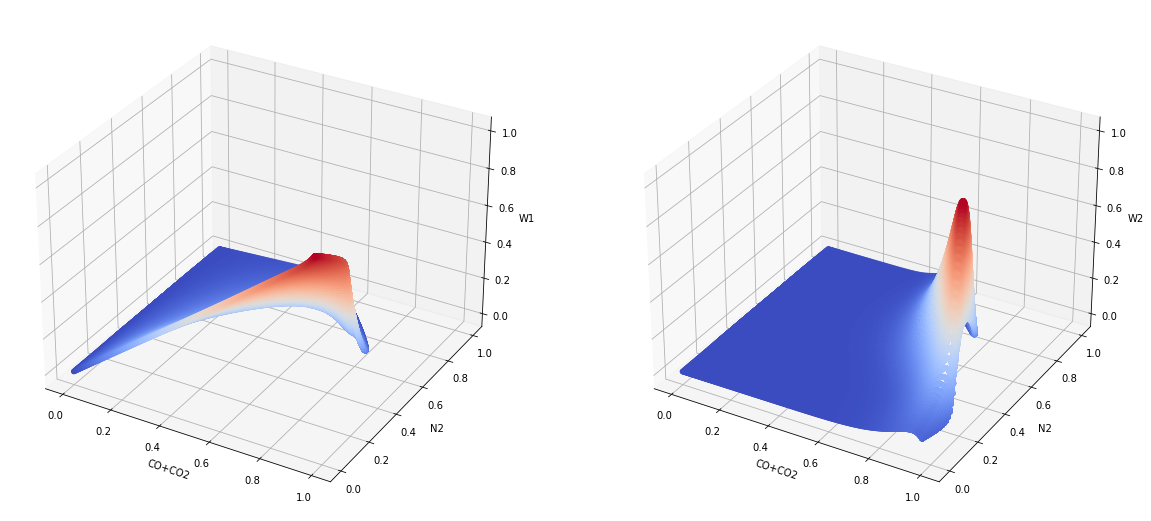

In [5]:
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y.cpu().data.numpy(), f"result/3D_plot-ann1-W-target.png")

# Model training

In [10]:
import torch.utils.data as Data

torch.manual_seed(1)    # reproducible

BATCH_SIZE = 64  # x.shape[0]

flame_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=flame_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False, )

## Define model

In [7]:
EPOCH = 500  # 500
lr = 0.01
decayRate = 0.96
token = f"epoch={EPOCH}-lr={lr:.3f}-decay={decayRate:.2f}"

In [8]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor

class FlameLoss(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'sum') -> None:
        super(FlameLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return torch.sum((target + 1) * (input - target) ** 2)

Start time = 2021-11-11 22:05:07.117318
End time = 2021-11-11 22:20:35.086003
Final MSEloss=832.025634765625


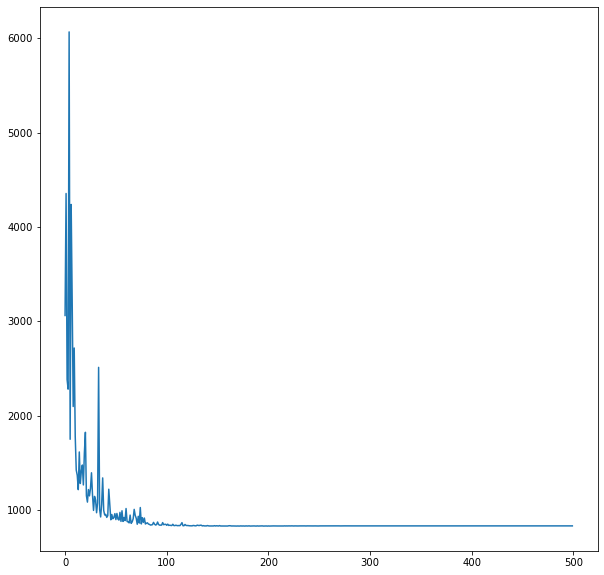

In [12]:
import imageio
from mpl_toolkits import mplot3d
import datetime
import numpy as np

net = torch.nn.Sequential(
        torch.nn.Linear(2, 160),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(160, 80),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(80, 80),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(80, 80),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(80, 49),
    ).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, decayRate)  # lr*gamma^step

loss_values = []

print(f"Start time = {datetime.datetime.now()}")

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)

        y_pred = net(b_x.float())
        loss = torch.nn.MSELoss(reduction='sum')(y_pred, b_y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate model:
    net.eval()
    with torch.no_grad():
        y_pred = net(x.float())
        mseLoss = torch.nn.MSELoss(reduction='sum')(y_pred, y.float())
        loss_values.append(mseLoss.cpu())

    # enable training
    net.train()
    lr_decay.step()

print(f"End time = {datetime.datetime.now()}")
print(f"Final MSEloss={mseLoss}")

fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values)
plt.savefig(f"result/3D_plot-ann1-W-train-{token}-loss={mseLoss:.6f}.png")
np.savetxt(f"result/3D_plot-ann1-W-train-{token}-loss={mseLoss:.6f}.csv", loss_values, delimiter =", ", fmt='%s')

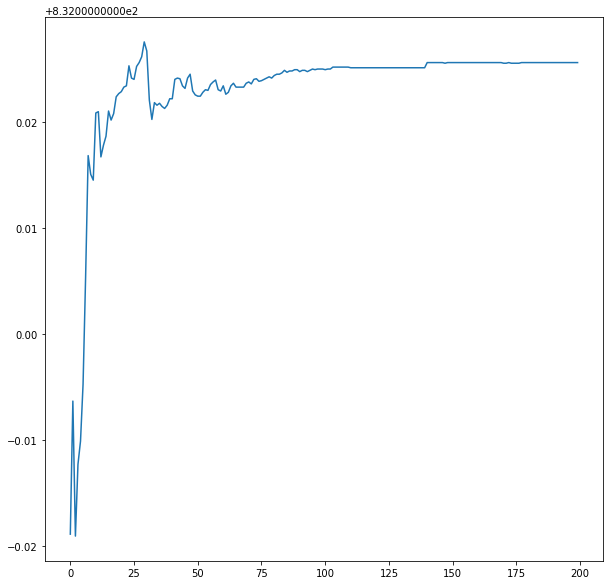

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values[-200:])
#print(f"loss[500]={loss_values[500]}, loss[-200]={loss_values[-200]}, loss[-1]={loss_values[-1]},")

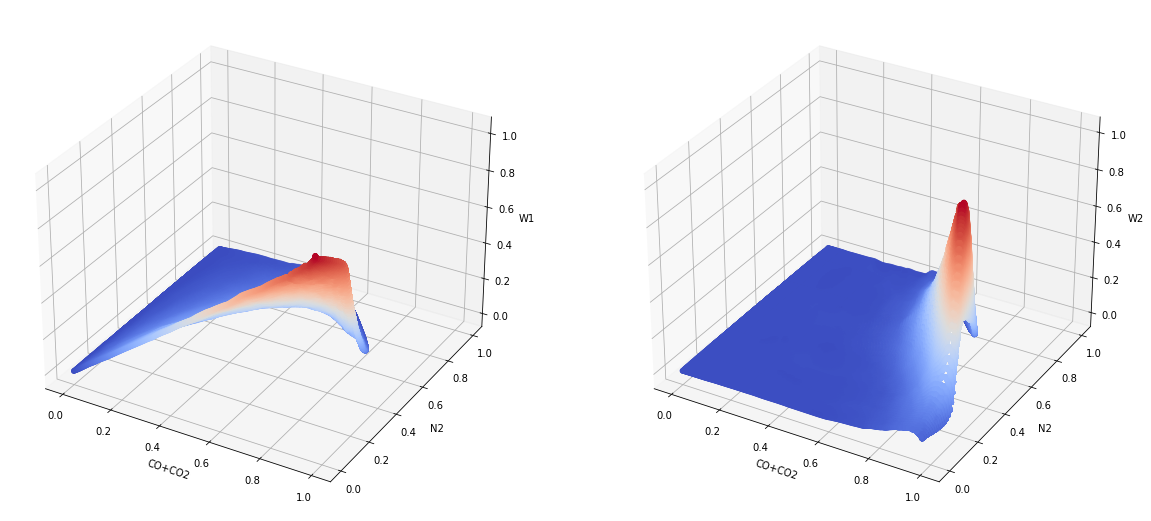

In [14]:
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_pred.cpu().data.numpy(), f"result/3D_plot-ann1-W-{token}-loss={mseLoss:.6f}.png")

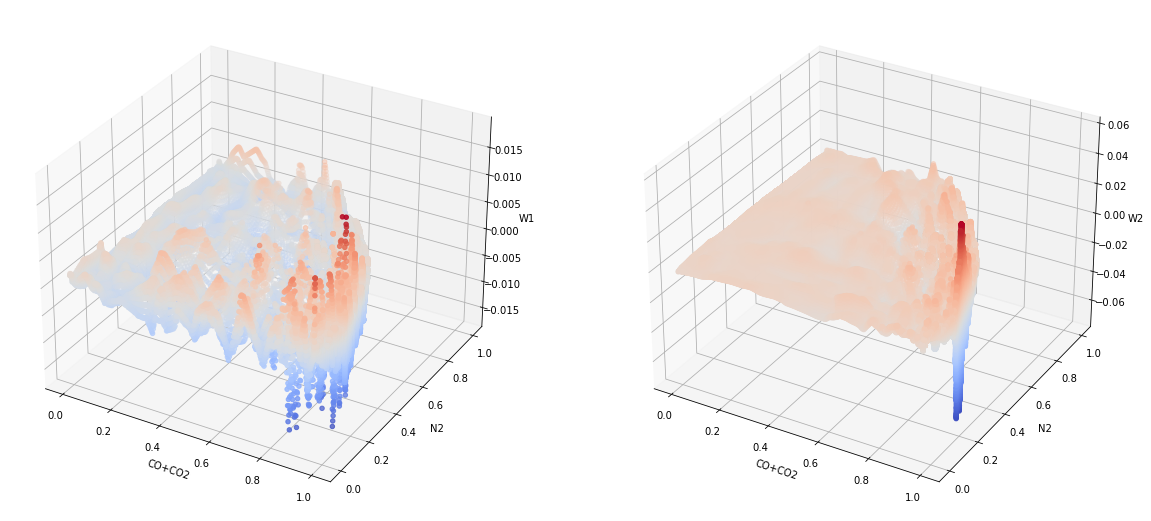

In [15]:
y_err = (y_pred-y).cpu().data.numpy()
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_err, f"result/3D_plot-ann1-W-{token}-err-loss={mseLoss:.6f}.png")

In [16]:
W1_min_max = df_min_max.iloc[3]  # for W1
W2_min_max = df_min_max.iloc[4]  # for W2

std_err = np.abs(y_err).max(axis=0)

W1_real_err = std_err[0] * (W1_min_max[1] - W1_min_max[0])
W2_real_err = std_err[1] * (W2_min_max[1] - W2_min_max[0])

print(f"W1 maximum real err={W1_real_err}, W2 maximum real err={W2_real_err}")

W1 maximum real err=6.655981901844398e-06, W2 maximum real err=0.00015913832666815216
